In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.api as sms
import numpy as np
from math import ceil

In [2]:
df=pd.read_csv(fr"/Users/choyy/Documents/AB_testing/ab_1/ab_data.csv")
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
# can ignore since, it is small enough, which mean can remove

duplicate=df.groupby('user_id').agg(count=('user_id','count')).reset_index()
##.squeeze() → Converts the single-column DataFrame into a Pandas Series.
duplicate = duplicate[duplicate['count'] > 1][['user_id']].squeeze().tolist()

df=df[~df['user_id'].isin(duplicate)]


In [5]:
control=df[df['group']=='control']
treatment=df[df['group']=='treatment']



In [6]:
#0.13 and 0.15 represent proportion
#Effect size measures the strength of the difference between these two proportions. 
#A larger effect size indicates a more significant difference between the two proportions
# a difference of 2%, we can use 13% and 15% to calculate the effect size we expect.
#use smaller values (like 0.06 and 0.08), you might not be able to detect small differences with a reasonable sample size,
#especially if you're aiming for 80% power. 
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

In [7]:
# power=0.8 (80%) → This is the statistical power, meaning there's an 80% probability of detecting a true difference if one exists.

# alpha=0.05 (5%) → This is the significance level (Type I error rate), meaning there's a 5% chance of incorrectly rejecting the null hypothesis when it's actually true.

# ratio=1 → This means equal-sized groups (e.g., treatment and control groups have the same number of observations).


required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


In [8]:
#extracting a random sample of a specific size (required_n) from the "control" group in a dataset.
# random_state makes randomness deterministic (consistent output).
# If multiple people are running tests, using a different random_state prevents them from getting the exact same results.
#  can use 23, 24, or any number—it just changes the random seed

control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)


ab_test=pd.concat([control_sample,treatment_sample])
ab_test.reset_index(drop=True, inplace=True)

In [9]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

In [10]:
ab_test


,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [11]:
#  visualize

conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


In [12]:

# cannot directly pass np.std or stats.sem without using lambda or defining a separate function,
#because these functions require additional parameters (ddof=0).

conversion_rates = ab_test.groupby('group').agg(
    conversion_rate=('converted', 'mean'),   # Mean conversion rate
    std_deviation=('converted', lambda x: np.std(x, ddof=0)),  # Standard deviation
    std_error=('converted', lambda x: stats.sem(x, ddof=0))  # Standard error, ddof=0 ensures we calculate the population standard deviation,
)

conversion_rates=conversion_rates.style.format('{:.3f}')
conversion_rates

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


C:\Users\choyy\AppData\Local\Temp\ipykernel_7772\1518086846.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)


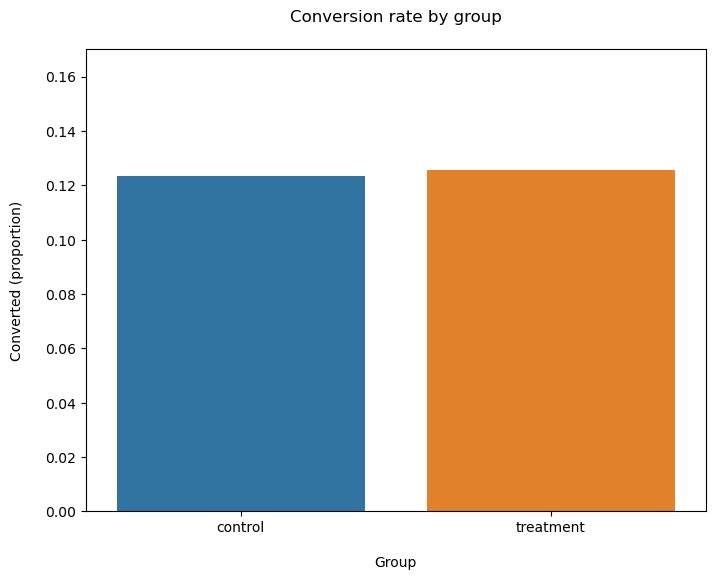

In [13]:

import seaborn as sns
plt.figure(figsize=(8,6))

# Disables confidence intervals (by default, Seaborn plots confidence intervals based on the standard error (ci)
sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

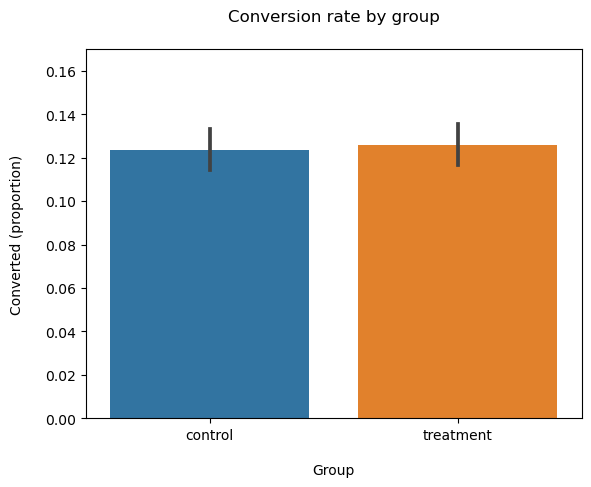

In [14]:


#  include confidenc interval
sns.barplot(x=ab_test['group'], y=ab_test['converted'])

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [19]:
#  testing
# proportions_ztest-Performs a Z-test for proportions.
#proportion_confint-Calculates the confidence interval (CI) for a proportion.
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# identify the converted for the control and treatment group
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

#  fix formula
# Make sure successes and nobs are lists/arrays of two values (one for control, one for treatment).
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


Conclusion:

Since p-value is more than the alpha value , 0.05. It does not reject the null hypothesis. It can be concluded that the new design is not significantly different than new design.

(b)
Looking for the confidence interval:
- 1. It includes our baseline value of 13% conversion rate
  2. It does not include our target value of 15% (the 2% uplift we were aiming for)
 
- it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for
